# Segmentation Model Training

##### 1. IMPORTS AND SETUP


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import segmentation_models_pytorch as smp
import json
from datetime import datetime

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


#### 2. CONFIGURATION


In [2]:
class Config:
    """Training configuration"""
    # Model
    MODEL_NAME = "deeplabv3plus"
    BACKBONE = "resnet50"
    IN_CHANNELS = 3
    NUM_CLASSES = 1  # Binary segmentation (piece vs background)
    
    # Data
    IMG_SIZE = (256, 256)  # Resize images to this size
    BATCH_SIZE = 8
    NUM_WORKERS = 0
    
    # Training
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # Paths (relative to notebooks directory)
    TRAIN_IMG_DIR = "../data/train/images"
    TRAIN_MASK_DIR = "../data/train/masks"
    VAL_IMG_DIR = "../data/val/images"
    VAL_MASK_DIR = "../data/val/masks"
    TEST_IMG_DIR = "../data/test/images"
    TEST_MASK_DIR = "../data/test/masks"
    
    # Output paths
    MODEL_DIR = "../output/training"
    OUTPUT_DIR = "../output/training"
    
    # Create directories
    Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

config = Config()

print("\n" + "="*70)
print("CONFIGURATION")
print("="*70)
print(f"Model: {config.MODEL_NAME} with {config.BACKBONE} backbone")
print(f"Image size: {config.IMG_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning rate: {config.LEARNING_RATE}")


CONFIGURATION
Model: deeplabv3plus with resnet50 backbone
Image size: (256, 256)
Batch size: 8
Epochs: 50
Learning rate: 0.0001


#### 3. DATASET CLASS


In [3]:
class PuzzleDataset(Dataset):
    """Dataset for puzzle piece segmentation"""
    
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted(list(self.img_dir.glob("*.jpg")))
        
        print(f"Found {len(self.image_files)} images in {img_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        try:
            # Load image
            img_path = self.image_files[idx]
            image = np.array(Image.open(img_path).convert("RGB"))
            
            # Load mask
            mask_name = img_path.stem + "_mask.png"
            mask_path = self.mask_dir / mask_name
            mask = np.array(Image.open(mask_path).convert("L"))
            
            # Normalize mask to 0 and 1
            mask = (mask > 0).astype(np.float32)
            
            # Apply transformations
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]
            
            return image, mask.unsqueeze(0)  # Add channel dimension to mask
        except Exception as e:
            print(f"Error loading {self.image_files[idx]}: {e}")
            raise

#### 4. DATA AUGMENTATION


In [4]:
def get_train_transform(img_size):
    """Training data augmentation"""
    return A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Small rotations, translations, and scaling
        A.Affine(
            translate_percent={"x": 0.1, "y": 0.1},
            rotate=(-15, 15),
            scale=(0.9, 1.1),  # uniform scaling
            p=0.5
        ),
        # Normalize for pretrained encoder
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transform(img_size):
    """Validation data augmentation (no augmentation, just normalization)"""
    return A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

### 5. CREATE DATALOADERS


In [5]:
print("\n" + "="*70)
print("CREATING DATALOADERS")
print("="*70)

# Create datasets
train_dataset = PuzzleDataset(
    config.TRAIN_IMG_DIR,
    config.TRAIN_MASK_DIR,
    transform=get_train_transform(config.IMG_SIZE)
)

val_dataset = PuzzleDataset(
    config.VAL_IMG_DIR,
    config.VAL_MASK_DIR,
    transform=get_val_transform(config.IMG_SIZE)
)

test_dataset = PuzzleDataset(
    config.TEST_IMG_DIR,
    config.TEST_MASK_DIR,
    transform=get_val_transform(config.IMG_SIZE)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print(f"\n✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")


CREATING DATALOADERS
Found 350 images in ../data/train/images
Found 75 images in ../data/val/images
Found 75 images in ../data/test/images

✓ Training batches: 44
✓ Validation batches: 10
✓ Test batches: 10


#### 6. MODEL INITIALIZATION


In [6]:
print("\n" + "="*70)
print("INITIALIZING MODEL")
print("="*70)

# Create model
model = smp.DeepLabV3Plus(
    encoder_name=config.BACKBONE,
    encoder_weights="imagenet",
    in_channels=config.IN_CHANNELS,
    classes=config.NUM_CLASSES
).to(device)

print(f"Model created: DeepLabV3+ with {config.BACKBONE} backbone")
print(f"Encoder initialized with ImageNet weights")


INITIALIZING MODEL
Model created: DeepLabV3+ with resnet50 backbone
Encoder initialized with ImageNet weights


#### 7. LOSS FUNCTION AND METRICS


In [7]:
class DiceLoss(nn.Module):
    """Dice Loss for binary segmentation"""
    
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined BCE and Dice Loss"""
    
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union (IoU)"""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.item()

# Initialize loss
criterion = CombinedLoss()
print("\nLoss function: Combined BCE + Dice Loss")


Loss function: Combined BCE + Dice Loss


#### 8. OPTIMIZER AND SCHEDULER


In [8]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5
)

print("Optimizer: AdamW")
print("Scheduler: ReduceLROnPlateau (monitors validation IoU)")

Optimizer: AdamW
Scheduler: ReduceLROnPlateau (monitors validation IoU)


#### 9. TRAINING LOOP

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    
    pbar = tqdm(loader, desc="Training")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        iou = calculate_iou(outputs, masks)
        
        running_loss += loss.item()
        running_iou += iou
        
        pbar.set_postfix({'loss': loss.item(), 'iou': iou})
    
    epoch_loss = running_loss / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_iou

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            iou = calculate_iou(outputs, masks)
            
            running_loss += loss.item()
            running_iou += iou
            
            pbar.set_postfix({'loss': loss.item(), 'iou': iou})
    
    epoch_loss = running_loss / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_iou

#### 10. TRAINING


In [10]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Training history
history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': [],
    'lr': []
}

best_val_iou = 0.0
patience_counter = 0
early_stop_patience = 10

for epoch in range(config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_iou = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_iou)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['lr'].append(current_lr)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        patience_counter = 0
        
        model_save_path = Path(config.MODEL_DIR) / f"deeplabv3plus_resnet50_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'config': config.__dict__
        }, model_save_path)
        
        print(f"✓ Best model saved! Val IoU: {val_iou:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best Validation IoU: {best_val_iou:.4f}")


STARTING TRAINING

Epoch 1/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it, loss=0.969, iou=0.659]


Train Loss: 1.0994 | Train IoU: 0.4905
Val Loss: 0.9674 | Val IoU: 0.6637
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.6637

Epoch 2/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it, loss=0.69, iou=0.708]


Train Loss: 0.7418 | Train IoU: 0.7025
Val Loss: 0.6698 | Val IoU: 0.7366
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.7366

Epoch 3/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.488, iou=0.782]


Train Loss: 0.5484 | Train IoU: 0.7658
Val Loss: 0.4707 | Val IoU: 0.8088
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.8088

Epoch 4/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.36, iou=0.847]


Train Loss: 0.4013 | Train IoU: 0.8329
Val Loss: 0.3300 | Val IoU: 0.8715
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.8715

Epoch 5/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.272, iou=0.874]


Train Loss: 0.2919 | Train IoU: 0.8840
Val Loss: 0.2413 | Val IoU: 0.9037
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9037

Epoch 6/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.216, iou=0.888]


Train Loss: 0.2258 | Train IoU: 0.9090
Val Loss: 0.1902 | Val IoU: 0.9221
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9221

Epoch 7/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.185, iou=0.893]


Train Loss: 0.1793 | Train IoU: 0.9231
Val Loss: 0.1566 | Val IoU: 0.9286
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9286

Epoch 8/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.17, iou=0.898]


Train Loss: 0.1527 | Train IoU: 0.9285
Val Loss: 0.1442 | Val IoU: 0.9327
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9327

Epoch 9/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.147, iou=0.899]


Train Loss: 0.1305 | Train IoU: 0.9340
Val Loss: 0.1198 | Val IoU: 0.9362
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9362

Epoch 10/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.132, iou=0.904]


Train Loss: 0.1148 | Train IoU: 0.9374
Val Loss: 0.1082 | Val IoU: 0.9355
Learning Rate: 0.000100

Epoch 11/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it, loss=0.119, iou=0.911]


Train Loss: 0.1022 | Train IoU: 0.9404
Val Loss: 0.0977 | Val IoU: 0.9414
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9414

Epoch 12/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.111, iou=0.914]


Train Loss: 0.0921 | Train IoU: 0.9436
Val Loss: 0.0879 | Val IoU: 0.9436
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9436

Epoch 13/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0995, iou=0.92]


Train Loss: 0.0843 | Train IoU: 0.9451
Val Loss: 0.0814 | Val IoU: 0.9458
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9458

Epoch 14/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0944, iou=0.921]


Train Loss: 0.0791 | Train IoU: 0.9454
Val Loss: 0.0767 | Val IoU: 0.9464
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9464

Epoch 15/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0903, iou=0.92]


Train Loss: 0.0730 | Train IoU: 0.9475
Val Loss: 0.0709 | Val IoU: 0.9480
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9480

Epoch 16/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0824, iou=0.928]


Train Loss: 0.0681 | Train IoU: 0.9492
Val Loss: 0.0670 | Val IoU: 0.9496
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9496

Epoch 17/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0827, iou=0.921]


Train Loss: 0.0651 | Train IoU: 0.9499
Val Loss: 0.0655 | Val IoU: 0.9465
Learning Rate: 0.000100

Epoch 18/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0742, iou=0.934]


Train Loss: 0.0618 | Train IoU: 0.9506
Val Loss: 0.0607 | Val IoU: 0.9524
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9524

Epoch 19/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0712, iou=0.93]


Train Loss: 0.0586 | Train IoU: 0.9516
Val Loss: 0.0580 | Val IoU: 0.9506
Learning Rate: 0.000100

Epoch 20/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0678, iou=0.934]


Train Loss: 0.0559 | Train IoU: 0.9526
Val Loss: 0.0540 | Val IoU: 0.9543
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9543

Epoch 21/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it, loss=0.0665, iou=0.934]


Train Loss: 0.0539 | Train IoU: 0.9533
Val Loss: 0.0527 | Val IoU: 0.9531
Learning Rate: 0.000100

Epoch 22/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0637, iou=0.936]


Train Loss: 0.0519 | Train IoU: 0.9539
Val Loss: 0.0509 | Val IoU: 0.9547
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9547

Epoch 23/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0655, iou=0.932]


Train Loss: 0.0505 | Train IoU: 0.9542
Val Loss: 0.0523 | Val IoU: 0.9519
Learning Rate: 0.000100

Epoch 24/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0577, iou=0.94]


Train Loss: 0.0483 | Train IoU: 0.9555
Val Loss: 0.0470 | Val IoU: 0.9561
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9561

Epoch 25/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0554, iou=0.943]


Train Loss: 0.0471 | Train IoU: 0.9557
Val Loss: 0.0460 | Val IoU: 0.9566
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9566

Epoch 26/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0583, iou=0.937]


Train Loss: 0.0458 | Train IoU: 0.9561
Val Loss: 0.0458 | Val IoU: 0.9551
Learning Rate: 0.000100

Epoch 27/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0534, iou=0.944]


Train Loss: 0.0446 | Train IoU: 0.9568
Val Loss: 0.0439 | Val IoU: 0.9576
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9576

Epoch 28/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0515, iou=0.946]


Train Loss: 0.0433 | Train IoU: 0.9573
Val Loss: 0.0412 | Val IoU: 0.9594
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9594

Epoch 29/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0489, iou=0.948]


Train Loss: 0.0424 | Train IoU: 0.9579
Val Loss: 0.0399 | Val IoU: 0.9605
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9605

Epoch 30/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0525, iou=0.942]


Train Loss: 0.0414 | Train IoU: 0.9582
Val Loss: 0.0407 | Val IoU: 0.9590
Learning Rate: 0.000100

Epoch 31/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.047, iou=0.948]


Train Loss: 0.0403 | Train IoU: 0.9588
Val Loss: 0.0391 | Val IoU: 0.9603
Learning Rate: 0.000100

Epoch 32/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0465, iou=0.947]


Train Loss: 0.0399 | Train IoU: 0.9589
Val Loss: 0.0383 | Val IoU: 0.9604
Learning Rate: 0.000100

Epoch 33/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0452, iou=0.95]


Train Loss: 0.0388 | Train IoU: 0.9596
Val Loss: 0.0371 | Val IoU: 0.9618
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9618

Epoch 34/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0453, iou=0.949]


Train Loss: 0.0382 | Train IoU: 0.9598
Val Loss: 0.0367 | Val IoU: 0.9614
Learning Rate: 0.000100

Epoch 35/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0438, iou=0.95]


Train Loss: 0.0372 | Train IoU: 0.9610
Val Loss: 0.0368 | Val IoU: 0.9607
Learning Rate: 0.000100

Epoch 36/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0414, iou=0.954]


Train Loss: 0.0368 | Train IoU: 0.9605
Val Loss: 0.0346 | Val IoU: 0.9634
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9634

Epoch 37/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0414, iou=0.953]


Train Loss: 0.0361 | Train IoU: 0.9613
Val Loss: 0.0353 | Val IoU: 0.9618
Learning Rate: 0.000100

Epoch 38/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.043, iou=0.951]


Train Loss: 0.0356 | Train IoU: 0.9615
Val Loss: 0.0347 | Val IoU: 0.9621
Learning Rate: 0.000100

Epoch 39/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0398, iou=0.954]


Train Loss: 0.0351 | Train IoU: 0.9616
Val Loss: 0.0338 | Val IoU: 0.9628
Learning Rate: 0.000100

Epoch 40/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0405, iou=0.953]


Train Loss: 0.0347 | Train IoU: 0.9618
Val Loss: 0.0341 | Val IoU: 0.9620
Learning Rate: 0.000100

Epoch 41/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0422, iou=0.949]


Train Loss: 0.0343 | Train IoU: 0.9618
Val Loss: 0.0344 | Val IoU: 0.9609
Learning Rate: 0.000100

Epoch 42/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0387, iou=0.954]


Train Loss: 0.0342 | Train IoU: 0.9618
Val Loss: 0.0323 | Val IoU: 0.9636
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9636

Epoch 43/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it, loss=0.0389, iou=0.955]


Train Loss: 0.0334 | Train IoU: 0.9625
Val Loss: 0.0321 | Val IoU: 0.9640
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9640

Epoch 44/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.0375, iou=0.956]


Train Loss: 0.0329 | Train IoU: 0.9630
Val Loss: 0.0317 | Val IoU: 0.9641
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9641

Epoch 45/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.0378, iou=0.955]


Train Loss: 0.0327 | Train IoU: 0.9630
Val Loss: 0.0308 | Val IoU: 0.9647
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9647

Epoch 46/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0366, iou=0.956]


Train Loss: 0.0322 | Train IoU: 0.9635
Val Loss: 0.0308 | Val IoU: 0.9648
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9648

Epoch 47/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it, loss=0.0385, iou=0.953]


Train Loss: 0.0319 | Train IoU: 0.9635
Val Loss: 0.0309 | Val IoU: 0.9641
Learning Rate: 0.000100

Epoch 48/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0389, iou=0.953]


Train Loss: 0.0317 | Train IoU: 0.9635
Val Loss: 0.0305 | Val IoU: 0.9645
Learning Rate: 0.000100

Epoch 49/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0353, iou=0.957]


Train Loss: 0.0310 | Train IoU: 0.9642
Val Loss: 0.0294 | Val IoU: 0.9660
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.9660

Epoch 50/50
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.0374, iou=0.955]

Train Loss: 0.0306 | Train IoU: 0.9647
Val Loss: 0.0300 | Val IoU: 0.9648
Learning Rate: 0.000100

TRAINING COMPLETE
Best Validation IoU: 0.9660


#### 11. PLOT TRAINING HISTORY



PLOTTING TRAINING HISTORY


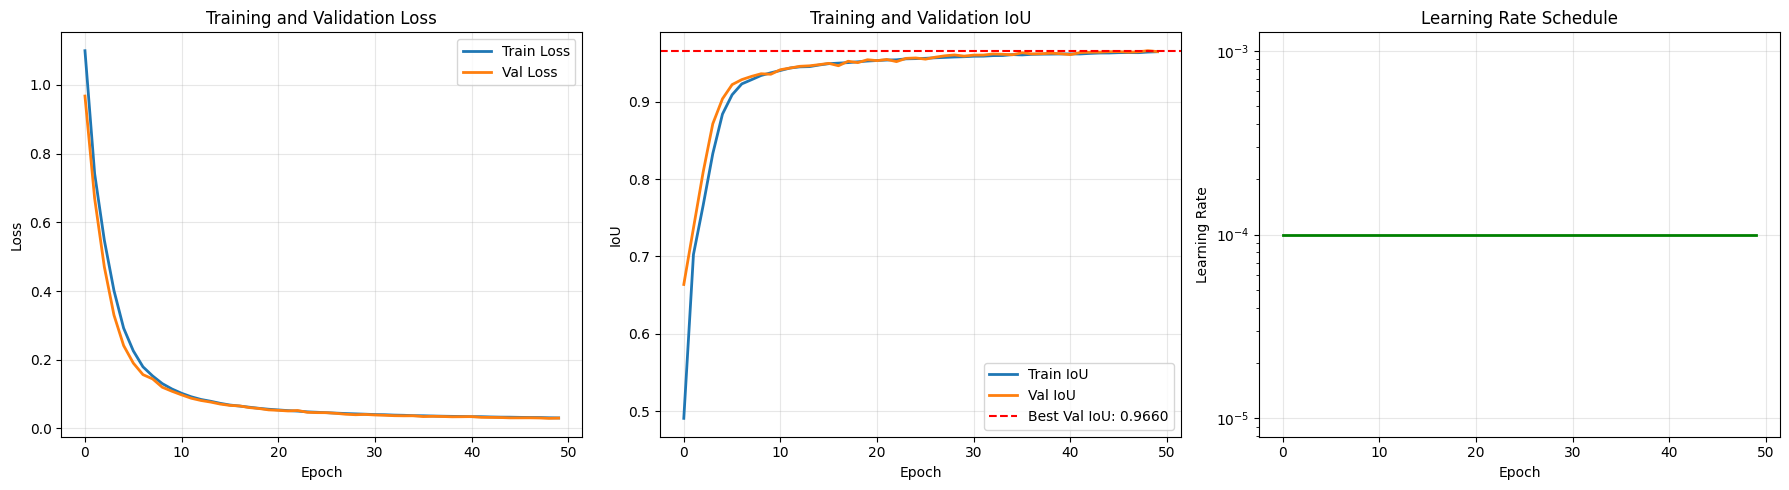

✓ Training history plots saved


In [11]:
print("\n" + "="*70)
print("PLOTTING TRAINING HISTORY")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU
axes[1].plot(history['train_iou'], label='Train IoU', linewidth=2)
axes[1].plot(history['val_iou'], label='Val IoU', linewidth=2)
axes[1].axhline(y=best_val_iou, color='r', linestyle='--', label=f'Best Val IoU: {best_val_iou:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/deeplabv3plus_resnet50_training_history.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved")

#### 12. EVALUATE ON TEST SET


In [12]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
checkpoint = torch.load(Path(config.MODEL_DIR) / "deeplabv3plus_resnet50_best.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Loaded best model weights")

# Evaluate
test_loss, test_iou = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  IoU: {test_iou:.4f}")


EVALUATING ON TEST SET
✓ Loaded best model weights


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it, loss=0.0324, iou=0.961]


Test Results:
  Loss: 0.0294
  IoU: 0.9660


#### 13. VISUALIZE PREDICTIONS


VISUALIZING PREDICTIONS


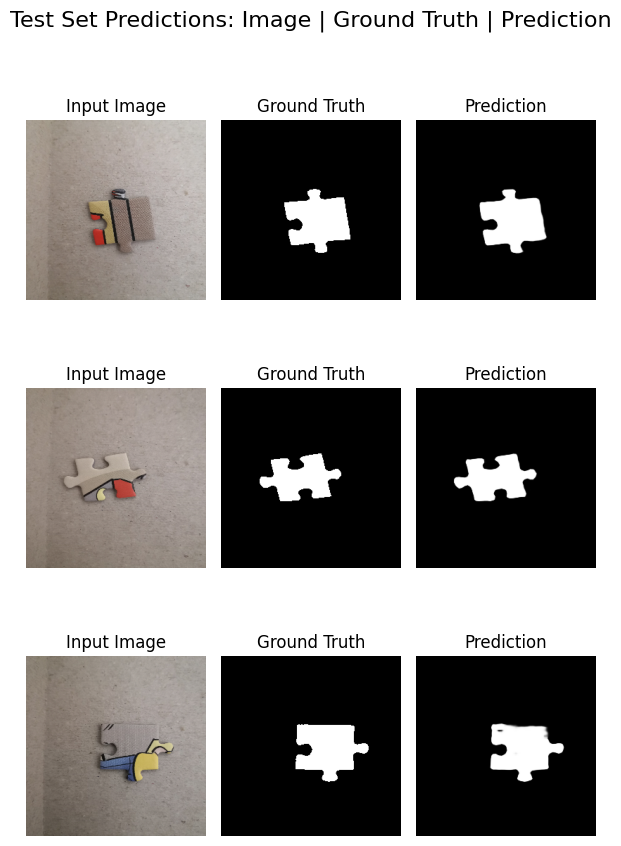

In [13]:
print("\n" + "="*70)
print("VISUALIZING PREDICTIONS")
print("="*70)

model.eval()
n_samples = 3

# Get random samples from test set
test_indices = np.random.choice(len(test_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 3, figsize=(6, 3*n_samples))
fig.suptitle('Test Set Predictions: Image | Ground Truth | Prediction', fontsize=16, y=1.00)

with torch.no_grad():
    for idx, test_idx in enumerate(test_indices):
        # Get sample
        image, mask = test_dataset[test_idx]
        
        # Predict
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0]
        
        # Denormalize image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_viz = image.permute(1, 2, 0).numpy()
        img_viz = (img_viz * std + mean).clip(0, 1)
        
        # Plot
        axes[idx, 0].imshow(img_viz)
        axes[idx, 0].set_title('Input Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask[0], cmap='gray')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_mask, cmap='gray')
        axes[idx, 2].set_title(f'Prediction')
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

#### 14. SAVE FINAL RESULTS


In [14]:
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

results = {
    'model': config.MODEL_NAME,
    'backbone': config.BACKBONE,
    'image_size': config.IMG_SIZE,
    'batch_size': config.BATCH_SIZE,
    'epochs_trained': len(history['train_loss']),
    'best_val_iou': float(best_val_iou),
    'test_iou': float(test_iou),
    'test_loss': float(test_loss),
    'final_lr': float(history['lr'][-1]),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'history': {k: [float(v) for v in vals] for k, vals in history.items()}
}

results_path = Path(config.OUTPUT_DIR) / "deeplabv3plus_resnet50_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved to {results_path}")

print("\n" + "="*70)
print("EXPERIMENT COMPLETE")
print("="*70)
print(f"\nFinal Results:")
print(f"  Best Validation IoU: {best_val_iou:.4f}")
print(f"  Test IoU: {test_iou:.4f}")


SAVING RESULTS
✓ Results saved to ..\output\training\deeplabv3plus_resnet50_results.json

EXPERIMENT COMPLETE

Final Results:
  Best Validation IoU: 0.9660
  Test IoU: 0.9660
